In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LSTM, MultiHeadAttention, LayerNormalization, Dropout, Add
from tensorflow.keras.models import Model
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\elecproduction.csv", header=0, index_col =0,parse_dates=['DATE'])
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [4]:
df = df.rename(columns={"IPG2211A2N": "value"})

In [5]:
scaler = MinMaxScaler()
df["value"] = scaler.fit_transform(df[["value"]])

df.head()

,value
DATE,
1985-01-01,0.232017
1985-02-01,0.207274
1985-03-01,0.096304
1985-04-01,0.029104
1985-05-01,0.000000


In [6]:
def create_sequences(data, history_size=30, future_size=10):
    X, y = [], []
    for i in range(len(data) - history_size - future_size):
        X.append(data[i:i+history_size])
        y.append(data[i+history_size:i+history_size+future_size])
    return np.array(X), np.array(y)

In [7]:
history_size = 30
future_size = 10
X, y = create_sequences(df["value"].values, history_size, future_size)

split = int(0.8 * len(X))
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

In [8]:
def build_tft_model(hp):
    input_layer = Input(shape=(history_size, 1))

    lstm_out = LSTM(
        units=hp.Int("lstm_units", min_value=32, max_value=128, step=32), 
        return_sequences=True
    )(input_layer)

    attn_out = MultiHeadAttention(
        num_heads=hp.Int("num_heads", 2, 8, step=2),
        key_dim=hp.Int("key_dim", 16, 64, step=16)
    )(lstm_out, lstm_out)
    
    attn_out = LayerNormalization()(Add()([lstm_out, attn_out]))
    attn_out = Dropout(rate=hp.Float("dropout", 0.1, 0.5, step=0.1))(attn_out)

    dense_out = Dense(future_size)(attn_out[:, -1, :])

    model = Model(inputs=input_layer, outputs=dense_out)
    model.compile(
        optimizer=keras.optimizers.Adam(hp.Float("learning_rate", 1e-4, 1e-2, sampling="log")),
        loss="mse",
        metrics=["mae"]
    )
    return model

In [9]:
tuner = kt.RandomSearch(
    build_tft_model,
    objective="val_loss",
    max_trials=1,
    executions_per_trial=1,
    directory="tft_tuning",
    project_name="tft_forecasting"
)

In [10]:
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32)

Trial 1 Complete [00h 00m 16s]
val_loss: 0.3114003539085388

Best val_loss So Far: 0.3114003539085388
Total elapsed time: 00h 00m 16s


In [11]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

In [12]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1, batch_size=32)

9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 238ms/step - loss: 1.6576 - mae: 1.0933 - val_loss: 1.0726 - val_mae: 0.9199


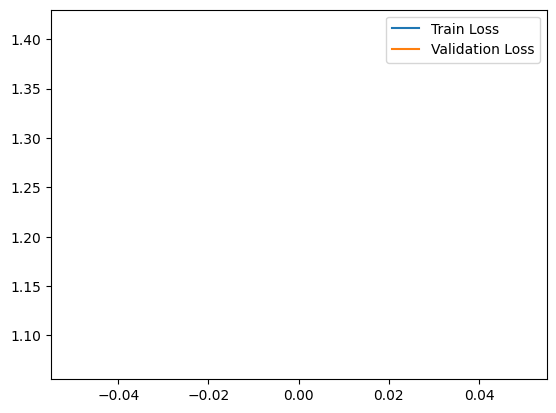

In [13]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [14]:
last_input = X_test[-1].reshape(1, history_size, 1)

In [15]:
predictions = model.predict(last_input).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


In [16]:
predictions = scaler.inverse_transform(predictions.reshape(-1, 1)).flatten()

In [17]:
print("Prediksi 10 periode ke depan:", predictions)

Prediksi 10 periode ke depan: [ 43.74889    35.52261   -26.446417  -17.185686   32.213356   79.08933
  49.359505  168.21754     5.6898513 116.68931  ]


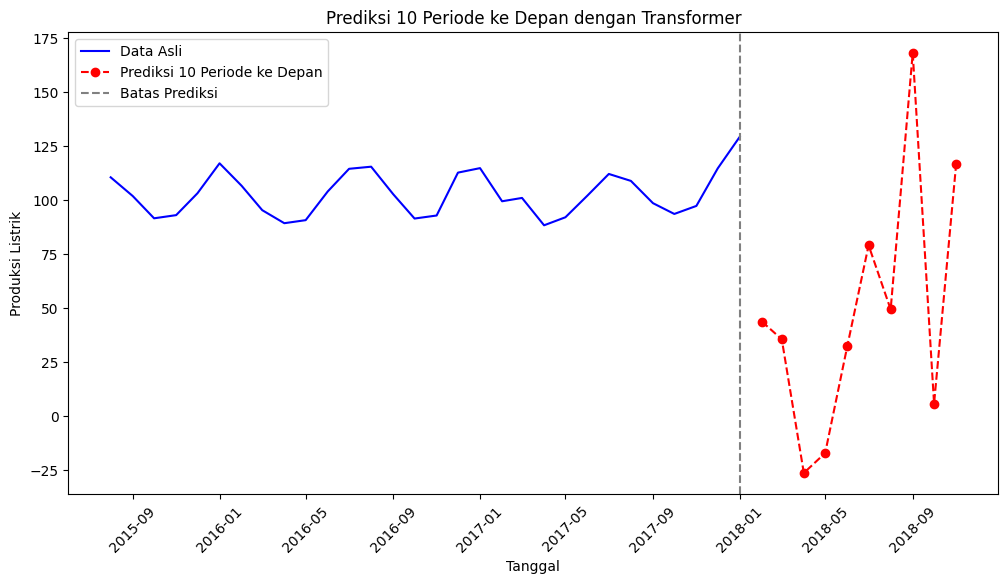

In [29]:
actual_dates = df.index.values[-(history_size + future_size):]
future_dates = pd.date_range(start=actual_dates[-1], periods=future_size + 1, freq="MS")[1:]

plt.figure(figsize=(12, 6))
plt.plot(df.index.values[-history_size:], scaler.inverse_transform(df[["value"]].values)[-history_size:], label="Data Asli", color="blue")
plt.plot(future_dates, predictions, label="Prediksi 10 Periode ke Depan", linestyle="dashed", color="red", marker="o")

plt.axvline(x=actual_dates[-1], color="gray", linestyle="--", label="Batas Prediksi")

plt.xlabel("Tanggal")
plt.ylabel("Produksi Listrik")
plt.legend()
plt.title("Prediksi 10 Periode ke Depan dengan Transformer")
plt.xticks(rotation=45)
plt.show()